# Anomaly Detection with Variational Autoencoders and Encoded Cluster Plots

This is my work for constructing and testing a Variational Autoencoder (VAE) that helps detect Alzheimer's Disease early using images from three linked conditions.

First, I did all relevant imports for this project and seeded everything.

In [ ]:
## All Imports ##
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from sklearn.manifold import TSNE
import pandas as pd
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision.datasets import ImageFolder
from torchvision import transforms

def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

set_seed(0)

train_set_pct = 1.0

Next, I mounted my google drive, where I unzipped all files downloaded in my local drive. All data was obtained from the article "Identifying Medical Diagnoses and Treatable Diseases by Image-Based Deep Learning" published in the journal Cell.

Citation for Data Usage:
Kermany D, Goldbaum M, Cai W et al. Identifying Medical Diagnoses and Treatable Diseases by Image-Based Deep Learning. Cell. 2018; 172(5):1122-1131. doi:10.1016/j.cell.2018.02.010.

In [ ]:
#MOUNTING THE DRIVE
from google.colab import drive
drive.mount('/content/drive')

!rsync -ah -progress "/content/drive/MyDrive/Colab Notebooks/Kermany Data/ZhangLabData.zip" "/content"
!unzip /content/ZhangLabData.zip

PATH_TRAIN = "/content/CellData/OCT/train"
PATH_TEST = "/content/CellData/OCT/test"

Streaming output truncated to the last 5000 lines.
  inflating: CellData/OCT/train/DME/DME-778975-125.jpeg  
  inflating: CellData/OCT/train/DME/DME-258763-26.jpeg  
  inflating: CellData/OCT/train/DME/DME-8457431-23.jpeg  
  inflating: CellData/OCT/train/DME/DME-3304080-55.jpeg  
  inflating: CellData/OCT/train/DME/DME-5006393-70.jpeg  
  inflating: CellData/OCT/train/DME/DME-5091309-15.jpeg  
  inflating: CellData/OCT/train/DME/DME-3064922-181.jpeg  
  inflating: CellData/OCT/train/DME/DME-8525575-184.jpeg  
  inflating: CellData/OCT/train/DME/DME-5143281-26.jpeg  
  inflating: CellData/OCT/train/DME/DME-6737988-35.jpeg  
  inflating: CellData/OCT/train/DME/DME-3064922-202.jpeg  
  inflating: CellData/OCT/train/DME/DME-3531101-20.jpeg  
  inflating: CellData/OCT/train/DME/DME-3157783-58.jpeg  
  inflating: CellData/OCT/train/DME/DME-258763-41.jpeg  
  inflating: CellData/OCT/train/DME/DME-30521-85.jpeg  
  inflating: CellData/OCT/train/DME/DME-5489583-15.jpeg  
  inflating: CellData/

## Preparing the Dataset

I defined the transformations, a class for loading the images which is used later, and built the train and test set for the optical coherence tomography (OCT) images. I also split off a random subset of the train data to train my EncoderForClassifier which is defined later.

In [ ]:
GRAY_MEAN = [0.5]
GRAY_STD = [0.5]

train_transform = transforms.Compose(
    [
        transforms.Lambda(lambda x: x.convert("L")),
        transforms.Resize((128,128)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=GRAY_MEAN, std=GRAY_STD)
    ]
)

val_transform = transforms.Compose(
    [
        transforms.Lambda(lambda x: x.convert("L")),
        transforms.Resize((128,128)),
        transforms.ToTensor(),
        transforms.Normalize(mean=GRAY_MEAN, std=GRAY_STD)
    ]
)

"""
Class for Loading Images
"""
class ImageLoaderDataset(nn.Module):
    def __init__(self, path_to_folder, transform):
        """
        Initializes instance of the ImageLoaderDataset Class

        Parameters:
        self (ImageLoaderDataset): instance of the class
        path_to_folder (str): the path to the data
        transform (transforms): the transformation to the data
        """

        self.path_to_folder = path_to_folder
        self.training_files = os.listdir(path_to_folder)
        self.transform = transform

    def __len__(self):
        """
        Returns the length of the data files

        Parameter:
        self (ImageLoaderDataset): instance of the class

        Returns:
        int: the length of training files
        """
        return len(self.training_files)

    def __getitem__(self, idx):
        """
        Gets the image at an index in the training files

        Parameters:
        self (ImageLoaderDataset): instance of the class
        idx (int): the index of the image you are returning

        Returns:
        Image: the image at that index
        """
        sample = self.training_files[idx]
        path_to_sample = os.path.join(self.path_to_folder, sample)

        image = Image.open(path_to_sample).convert("L")
        image = self.transform(image)

        return image

## Using Image Folder to Build the Train and Test Dataset ##
train_set = ImageFolder(PATH_TRAIN, transform=train_transform)
test_set = ImageFolder(PATH_TEST, transform=train_transform)

## Assigning Each Class an index ##
data_classes = {idx: val for (idx, val) in enumerate(train_set.classes)}

## Choosing a Random Subset for Pretraining ##
random_indices = random.sample(range(len(train_set)), int(len(train_set) * train_set_pct))
train_set = Subset(train_set, random_indices)

print(f"Training with {len(train_set)} samples")

Training with 108309 samples


## Defining ResidualBlocks & The Encoder

Next, I defined a class for ResidualBlocks and the other key encoding classes: the EncoderBlocks, the Encoder, and the EncoderForClassifier, which I will later train on the subset of the data.

In [ ]:
"""
ResidualBlock: a class that represents a block of residual connections
"""
class ResidualBlock(nn.Module):

    def __init__(self,
                 in_channels,
                 out_channels,
                 dropout_p=0.0):
        """
        Initializes the ResidualBlock class.

        Parameters:
        self (Residual Block): instance of the class
        in_channels (int): number of input channels
        out_channels (int): number of output channels
        dropout_p (float): dropout probability percent if you are randomly turning off some % of nodes, set to 0
        """

        super().__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding="same")
        self.norm1 = nn.BatchNorm2d(out_channels)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding="same")
        self.norm2 = nn.BatchNorm2d(out_channels)

        self.identity_conv = nn.Identity()
        if in_channels != out_channels:
            self.identity_conv = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1)

    def forward(self, x):
        """
        Forward function for ResidualBlock. Applies a residual connection by applying a convolution
        that goes from the input channels to the output channels with stride=1, applies a BatchNorm2d and
        then the activation function. Applies a second convolution from output channels to output channels and
        a BatchNorm2d and then activation again. Finally, it has the residual effect by adding the identity on the residual.

        Parameters:
        self (ResidualBlock): instance of the class
        x: the input to the block

        Returns:
        x: the output after adding the residual
        """
        residual = x

        x = self.conv1(x)
        x = self.norm1(x)
        x = F.relu(x)

        x = self.conv2(x)
        x = self.norm2(x)
        x = F.relu(x)

        x = x + self.identity_conv(residual)

        return x

"""
EncoderBlock: a class that defines the structure and ResidualBlocks that make up the Encoder
of my VAE.
"""
class EncoderBlock(nn.Module):
    def __init__(self,
                 in_channels,
                 out_channels,
                 residual_blocks_per_group=1,
                 downsample=True,
                 dropout_p=0.0):
      """
      Initializes an instance of the EncoderBlock class.

      Parameters:
      self (EncoderBlock): instance of the class
      in_channels (int): number of input channels
      out_channels (int): number of output channels
      residual_blocks_per_group (int): number of ResidualBlocks per group, set to 1
      downsample (bool): True if downsampling, else False
      dropout_p(float): % of nodes randomly turned off, set to 0.0
      """

      super().__init__()

      self.encoder_block = nn.ModuleList([])
      for i in range(residual_blocks_per_group):
          in_c = in_channels if i == 0 else out_channels
          self.encoder_block.append(
              ResidualBlock(in_c, out_channels, dropout_p)
          )

      if downsample:
          self.encoder_block.append(
              nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=2, padding=1)
          )

    def forward(self, x):
        """
        Forward function for the EncoderBlock that specifies how input flows through the network.

        Parameters:
        self (EncoderBlock): instance of the class
        x: the input passed to the layer
        """

        for block in self.encoder_block:
            x = block(x)

        return x
"""
Encoder: encoder class for the VAE, which has a sequence of EncoderBlocks which go through a channel pattern
and which downsample.
"""
class Encoder(nn.Module):
    """
    Initializes the Encoder class

    Parameters:
    self (Encoder): instance of the class
    in_channels (int): number of input channels
    channel_pattern (array): the pattern of number of channels for the encoder.
                            If None, default is [32,64,128,256]
    residual_blocks_per_group (int): the number of residual blocks per group, set to 1
    dropout_p (float): percent of nodes randomly turned off, set to 0.0
    """
    def __init__(self,
                  in_channels,
                  channel_pattern=None,
                  residual_blocks_per_group=1,
                  dropout_p=0.0):

        super().__init__()

        self.channel_pattern = channel_pattern
        if channel_pattern is None:
            self.channel_pattern = [32,64,128,256]


        self.blocks1 = EncoderBlock(in_channels,
                                    self.channel_pattern[0],
                                    residual_blocks_per_group=residual_blocks_per_group,
                                    downsample=True,
                                    dropout_p=dropout_p)

        self.blocks2 = EncoderBlock(self.channel_pattern[0],
                                    self.channel_pattern[1],
                                    residual_blocks_per_group=residual_blocks_per_group,
                                    downsample=True,
                                    dropout_p=dropout_p)

        self.blocks3 = EncoderBlock(self.channel_pattern[1],
                                    self.channel_pattern[2],
                                    residual_blocks_per_group=residual_blocks_per_group,
                                    downsample=True,
                                    dropout_p=dropout_p)

        self.blocks4 = EncoderBlock(self.channel_pattern[2],
                                    self.channel_pattern[3],
                                    residual_blocks_per_group=residual_blocks_per_group,
                                    downsample=True,
                                    dropout_p=dropout_p)

    def forward(self, x):
        """
        The forward function for the Encoder that specifies how input flows through the
        network. It goes through all 4 encoder blocks.
        """

        x = self.blocks1(x)
        x = self.blocks2(x)
        x = self.blocks3(x)
        x = self.blocks4(x)

        return x

"""
EncoderForClassifier: This is the encoder which learns the classification, being
trained later on just a percent of the data. I will use this to load pretrained weights
to the encoder of the VAE later.
"""
class EncoderForClassifier(nn.Module):
    """
    Initializes the EncoderForClassifier.

    Parameters:
    self (Encoder): instance of the class
    num_classes (int): number of classes, set to four since the OCT dataset has four
    in_channels (int): number of input channels
    channel_pattern (array): the pattern of number of channels for the encoder.
                            If None, default is [32,64,128,256]
    residual_blocks_per_group (int): the number of residual blocks per group, set to 1
    dropout_p (float): percent of nodes randomly turned off, set to 0.0
    """
    def __init__(self,
                  num_classes=4,
                  in_channels=3,
                  channel_pattern=None,
                  residual_blocks_per_group=1,
                  dropout_p=0.0):
        super().__init__()

        self.encoder = Encoder(in_channels,
                                channel_pattern=None,
                                residual_blocks_per_group=1,
                                dropout_p=0.0)

        self.head = nn.Linear(self.encoder.channel_pattern[-1] * 8 * 8, num_classes)
    """
    Forward function for the EncoderForClassifier

    Parameters:
    self (EncoderForClassifier): instance of the class
    x: input passed to EncoderForClassifier
    """
    def forward(self, x):
        x = self.encoder(x)
        x = x.flatten(1)
        x = self.head(x)
        return x


## Train Classifier on Subset

Here, I wrote my training script and trained the EncoderForClassifier on a subset of the data. I also saved the state dict of the encoder with the file name "vae18_encoder" + str(train_set_pct*100) +"_c.pt," so for example, if I trained the model on 10% it would be saved to vae18_encoder10.0_c.pt. I saved all these state dicts through my experimentation.

In [ ]:
"""
Training function for the EncoderForClassifier

Parameters:
model: the model being trained
device: the device being used
epochs (int): number of epochs
optimizer: the optimizer
loss_fn: the loss function
trainloader: the data loader for the training data
valloader: the data loader for the test data

Returns:
log_training: the training log that specifies the epoch, training loss, training
accuracy, validation loss, and validation accuracy.
model: the model
"""
def train(model, device, epochs, optimizer, loss_fn, trainloader, valloader):
    log_training = {"epoch": [],
                    "training_loss": [],
                    "training_acc": [],
                    "validation_loss": [],
                    "validation_acc": []}

    model = model.to(device)

    for epoch in range(1, epochs + 1):
        print(f"Starting Epoch {epoch}")
        training_losses, training_accuracies = [], []
        validation_losses, validation_accuracies = [], []

        model.train()
        for image, label in tqdm(trainloader):
            image, label = image.to(device), label.to(device)
            optimizer.zero_grad()
            out = model.forward(image)

            ## Calculate Loss ##
            loss = loss_fn(out, label)
            training_losses.append(loss.item())

            ## Calculate Accuracy ##
            predictions = torch.argmax(out, axis=1)
            accuracy = (predictions == label).sum() / len(predictions)
            training_accuracies.append(accuracy.item())

            loss.backward()
            optimizer.step()

        model.eval() ## BatchNorm is Off ##
        for image, label in tqdm(valloader):
            image, label = image.to(device), label.to(device)
            with torch.no_grad():
                out = model.forward(image)

                ## Calculate Loss ##
                loss = loss_fn(out, label)
                validation_losses.append(loss.item())

                ## Calculate Accuracy ##
                predictions = torch.argmax(out, axis=1)
                accuracy = (predictions == label).sum() / len(predictions)
                validation_accuracies.append(accuracy.item())

        training_loss_mean, training_acc_mean = np.mean(training_losses), np.mean(training_accuracies)
        valid_loss_mean, valid_acc_mean = np.mean(validation_losses), np.mean(validation_accuracies)

        log_training["epoch"].append(epoch)
        log_training["training_loss"].append(training_loss_mean)
        log_training["training_acc"].append(training_acc_mean)
        log_training["validation_loss"].append(valid_loss_mean)
        log_training["validation_acc"].append(valid_acc_mean)

        print("Training Loss:", training_loss_mean)
        print("Training Acc:", training_acc_mean)
        print("Validation Loss:", valid_loss_mean)
        print("Validation Acc:", valid_acc_mean)

    return log_training, model

model = EncoderForClassifier(in_channels=1)
device = "cuda" if torch.cuda.is_available() else "cpu"
epochs = 5
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.01)
loss_fn = nn.CrossEntropyLoss()
trainloader = DataLoader(train_set, batch_size=64, shuffle=True, num_workers=16)
testloader = DataLoader(test_set, batch_size=64, shuffle=False, num_workers=16)

log_training, model = train(model=model,
                            device=device,
                            epochs=epochs,
                            optimizer=optimizer,
                            loss_fn=loss_fn,
                            trainloader=trainloader,
                            valloader=testloader)

## Saving the State Dict ##
torch.save(model.encoder.state_dict(), "vae18_encoder" + str(train_set_pct*100) +"_c.pt")

Starting Epoch 1


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


  0%|          | 0/1693 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Training Loss: 0.3287359461676807
Training Acc: 0.8876606756177655
Validation Loss: 0.39623615494929254
Validation Acc: 0.8597656264901161
Starting Epoch 2


  0%|          | 0/1693 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Training Loss: 0.17939100601439179
Training Acc: 0.9408317336089781
Validation Loss: 0.13066067930776626
Validation Acc: 0.9535156264901161
Starting Epoch 3


  0%|          | 0/1693 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Training Loss: 0.14600395271802136
Training Acc: 0.9518417046398223
Validation Loss: 0.23965540330391377
Validation Acc: 0.9291015639901161
Starting Epoch 4


  0%|          | 0/1693 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Training Loss: 0.12575226986304375
Training Acc: 0.9583847530481031
Validation Loss: 0.3883083076943876
Validation Acc: 0.8837890625
Starting Epoch 5


  0%|          | 0/1693 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Training Loss: 0.11396695394729078
Training Acc: 0.962640283520378
Validation Loss: 0.10766135656740516
Validation Acc: 0.970703125


### Defining my VAE

I defined the main Variational Autoencoder model. Of course, I had to define relevant classes including the class for upsampling and the Decoder (along with the DecoderBlock) for this task.

In [ ]:
"""
UpsampleBlock: Class for Upsampling for the VAE since Residual COnnections alone don't
change image resolution
"""
class UpsampleBlock(nn.Module):
    def __init__(self,
                  in_channels,
                  out_channels):
        """
        Initializes UpsampleBlock

        Parameters:
        self (UpsampleBlock): instance of the class
        in_channels (int): number of input channels
        out_channels (int): number of output channels
        """
        super().__init__()

        self.up = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding="same")
        )

    def forward(self, x):
        """
        Forward function for UpsampleBlock that applies upsampling to the input

        Parameters:
        self (UpSampleBlock): instance of the class
        x: input passed into model
        """
        return self.up(x)

"""
DecoderBlock: a class that details the structure of residual blocks in the decoder.
"""
class DecoderBlock(nn.Module):
    def __init__(self,
                 in_channels,
                 out_channels,
                 residual_blocks_per_group=1,
                 upsample=True,
                 dropout_p=0.0):
        """
        Initializes the DecoderBlock.

        Parameters:
        self (DecoderBlock): instance of the class
        in_channels (int): number of input channels
        out_channels (int): number of output channels
        residual_blocks_per_group (int): number of ResidualBlocks per group, set to 1
        upsample (bool): True if upsampling, else False
        dropout_p(float): % of nodes randomly turned off, set to 0.0

        """

        super().__init__()

        self.encoder_block = nn.ModuleList([])
        for i in range(residual_blocks_per_group):
            in_c = in_channels if i == 0 else out_channels
            self.encoder_block.append(
                ResidualBlock(in_c, out_channels, dropout_p)
            )

        if upsample:
            self.encoder_block.append(
                UpsampleBlock(out_channels, out_channels)
            )

    def forward(self, x):
        """
        Forward function for the DecoderBlock that specifies how input
        flows through the network's layers.

        Parameters:
        self (DecoderBlock): instance of the class
        x: the input passed to the layer
        """
        for block in self.encoder_block:
            x = block(x)

        return x

"""
Decoder: decoder class for the VAE, which has a sequence of DecoderBlocks which go through a channel pattern
and which upsample.
"""
class Decoder(nn.Module):
    def __init__(self,
                 out_channels,
                 channel_pattern=None,
                 residual_blocks_per_group=1,
                 dropout_p=0.0):
        """
        Initializes the Encoder class

        Parameters:
        self (Decoder): instance of the class
        out_channels (int): number of output channels
        channel_pattern (array): the pattern of number of channels for the encoder.
                                  If None, default is [32,64,128,256]
        residual_blocks_per_group (int): the number of residual blocks per group, set to 1
        dropout_p (float): percent of nodes randomly turned off, set to 0.0
        """
        super().__init__()

        self.channel_pattern = channel_pattern
        if channel_pattern is None:
            self.channel_pattern = [32,64,128,256]
        self.channel_pattern = list(reversed(self.channel_pattern))

        self.blocks1 = DecoderBlock(self.channel_pattern[0],
                                    self.channel_pattern[1],
                                    residual_blocks_per_group=residual_blocks_per_group,
                                    upsample=True,
                                    dropout_p=dropout_p)

        self.blocks2 = DecoderBlock(self.channel_pattern[1],
                                    self.channel_pattern[2],
                                    residual_blocks_per_group=residual_blocks_per_group,
                                    upsample=True,
                                    dropout_p=dropout_p)

        self.blocks3 = DecoderBlock(self.channel_pattern[2],
                                    self.channel_pattern[3],
                                    residual_blocks_per_group=residual_blocks_per_group,
                                    upsample=True,
                                    dropout_p=dropout_p)

        self.blocks4 = DecoderBlock(self.channel_pattern[3],
                                    out_channels,
                                    residual_blocks_per_group=residual_blocks_per_group,
                                    upsample=True,
                                    dropout_p=dropout_p)

    def forward(self, x):
        """
        The forward function for the Decoder that specifies how input flows through the
        network. It goes through all 4 decoder blocks.
        """
        x = self.blocks1(x)
        x = self.blocks2(x)
        x = self.blocks3(x)
        x = self.blocks4(x)

        return x

"""
VAE: Variational Autoencoder
"""
class VAE(nn.Module):
    def __init__(self,
                 in_channels,
                 latent_channels=16,
                 channel_pattern=None,
                 residual_blocks_per_group=1,
                 dropout_p=0.0):
        """
        Initializes the VAE class

        Parameters:
        self (VAE): instance of the class
        in_channels (int): number of input channels
        latent_channels (int): number of latent channels
        channel_pattern (array): the pattern of number of channels for the encoder.
                                  If None, default is [32,64,128,256]
        residual_blocks_per_group (int): the number of residual blocks per group, set to 1
        dropout_p (float): percent of nodes randomly turned off, set to 0.0
        """
        super().__init__()

        self.channel_pattern = channel_pattern
        if channel_pattern is None:
            self.channel_pattern = [32,64,128,256]

        self.encoder = Encoder(in_channels=in_channels,
                               channel_pattern=self.channel_pattern,
                               residual_blocks_per_group=residual_blocks_per_group,
                               dropout_p=dropout_p)

        self.decoder = Decoder(out_channels=in_channels,
                               channel_pattern=self.channel_pattern,
                               residual_blocks_per_group=residual_blocks_per_group,
                               dropout_p=dropout_p)

        self.proj_to_latent = nn.Conv2d(self.channel_pattern[-1],
                                        latent_channels * 2,
                                        kernel_size=1,
                                        padding="same")

        self.latent_to_proj = nn.Conv2d(latent_channels,
                                        self.channel_pattern[-1],
                                        kernel_size=1,
                                        padding="same")

    def kl_loss(self, mean, logvar):
        """
        Loss function for kL divergence, finds the loss for each pixel
        and then averages it.

        Parameters:
        self (VAE): instance of class
        mean (float): the mean
        logvar (float): the log variance
        """
        var = torch.exp(logvar)

        kl_loss = -0.5 * torch.sum(
            1 + logvar - mean**2 - var,
            dim=[1,2,3]
        )

        kl_loss = kl_loss.mean()

        return kl_loss

    def encode(self, x):
        """
        Function that describes how the VAE encodes: following the channel pattern, projecting to 2*latent space
        and then finding the mu and logvar.
        Pretrained weights will be added for the no_grad() portion of it.

        Parameters:
        self (VAE): instance of class
        x: the input passed in to the encoder

        Returns:
        z: the probabilistic distribution
        mu: the mean
        logvar: the log variance
        """
        with torch.no_grad():
            x = self.encoder(x)

        x = self.proj_to_latent(x)

        mu, logvar = torch.chunk(x, chunks=2, dim=1)
        logvar = torch.clamp(logvar, min=-30, max=20)
        sigma = torch.exp(0.5 * logvar)
        noise = torch.randn_like(sigma, device=sigma.device, dtype=sigma.dtype)
        z = mu + sigma * noise

        return z, mu, logvar

    def decode(self, x):
        """
        Function that does the decoding. Goes from the latent/bottleneck space then the
        decoder blocks.

        Parameters:
        self (VAE): instance of class
        x: input
        """

        x = self.latent_to_proj(x)
        x = self.decoder(x)

        return x

    def forward(self, x):
        """
        The forward function for the VAE. Goes through the encoder and decoder.

        Parameters:
        self (VAE): instance of class
        x: input

        Returns:
        enc: the encoded features
        dec: the decoded image
        kl_loss: the kL loss
        """

        enc, mu, logvar = self.encode(x)
        dec = self.decode(enc)

        kl_loss = self.kl_loss(mu, logvar)

        return enc, dec, kl_loss


### Training the VAE ###

Next, I trained my VAE.

In [ ]:
def train(model,
          kl_weight,
          train_set,
          test_set,
          batch_size,
          training_iterations,
          evaluation_iterations):
    """
    Training Script for the VAE.

    Parameters:
    model: the model
    kl_weight: the weight for the kL divergence loss
    train_set: the train set
    test_set: the test set
    batch_size: the batch size
    training_iterations: the number of training iterations
    evaluation_iterations: the number of evaluation iterations

    Returns:
    model: the model
    train_losses: the train losses
    evaluation_losses: the evaluation losses
    encoded_data_per_eval: the encoded data
    """

    device = "cuda" if torch.cuda.is_available() else "cpu"

    model = model.to(device)

    trainloader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=8)
    testloader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=8)

    params_to_train = filter(lambda p: p.requires_grad, model.parameters())
    optimizer = torch.optim.AdamW(params_to_train, lr=0.0001, weight_decay=0.001)

    train_loss = []
    evaluation_loss = []

    encoded_data_per_eval = []
    train_losses = []
    evaluation_losses = []

    pbar = tqdm(range(training_iterations))

    train = True

    step_counter = 0
    while train:

        for images in trainloader:

            images = images.to(device)

            enc, dec, kl_loss = model(images)

            reconstruction_loss = torch.sum((dec - images)**2) / len(images)

            loss = reconstruction_loss + kl_weight * kl_loss

            train_loss.append(loss.item())

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            if step_counter % evaluation_iterations == 0:

                model.eval()

                encoded_evaluations = []

                for images, labels in testloader:

                    images = images.to(device)

                    enc, dec, kl_loss = model(images)
                    reconstruction_loss = torch.sum((dec - images)**2) / len(images)

                    loss = reconstruction_loss + kl_weight * kl_loss

                    evaluation_loss.append(loss.item())

                    encoded, labels = enc.cpu().flatten(1), labels.reshape(-1,1)

                    encoded_evaluations.append(torch.cat((encoded, labels), axis=-1))


                encoded_data_per_eval.append(torch.concatenate(encoded_evaluations).detach())

                train_loss = np.mean(train_loss)
                evaluation_loss = np.mean(evaluation_loss)

                train_losses.append(train_loss)
                evaluation_losses.append(evaluation_loss)

                print("Training Loss", train_loss)
                print("Testing Loss", evaluation_loss)

                train_loss = []
                evaluation_loss = []

                model.train()

            step_counter += 1
            pbar.update(1)


            if step_counter >= training_iterations:
                print("Completed Training!")
                train = False
                break

    encoded_data_per_eval = [np.array(i) for i in encoded_data_per_eval]

    print("Final Training Loss", train_losses[-1])
    print("Final Evaluation Loss", evaluation_losses[-1])

    return model, train_losses, evaluation_losses, encoded_data_per_eval

model = VAE(in_channels=1)
model.encoder.load_state_dict(torch.load("vae18_encoder"+str(train_set_pct*100)+"_c.pt", weights_only=True))

def disable_update(module):
    for param in module.parameters():
        param.requires_grad_(False)

kl_weight = 0.5
train_set = ImageLoaderDataset("/content/CellData/OCT/train/NORMAL", transform=train_transform)
test_set = ImageFolder("/content/CellData/OCT/test", transform=val_transform)
batch_size = 64
training_iterations = 5000
evaluation_iterations = 500

model, train_losses, evaluation_losses, encoded_data_per_eval = train(model,
                                                                      kl_weight,
                                                                      train_set,
                                                                      test_set,
                                                                      batch_size,
                                                                      training_iterations,
                                                                      evaluation_iterations)

  0%|          | 0/5000 [00:00<?, ?it/s]

Training Loss 21182.46484375
Testing Loss 18006.488647460938
Training Loss 2102.8975041503904
Testing Loss 1770.0380935668945
Training Loss 949.49090234375
Testing Loss 1333.6033096313477
Training Loss 745.9510548095703
Testing Loss 1164.5093688964844
Training Loss 645.516153930664
Testing Loss 1046.6755599975586
Training Loss 575.3675629882813
Testing Loss 965.804859161377
Training Loss 526.2613145141602
Testing Loss 932.2663955688477
Training Loss 492.1071329345703
Testing Loss 837.8578186035156
Training Loss 462.28045538330076
Testing Loss 810.5754451751709
Training Loss 438.29439453125
Testing Loss 759.3272552490234
Completed Training!
Final Training Loss 438.29439453125
Final Evaluation Loss 759.3272552490234


I saved the state_dict each time.



In [ ]:
torch.save(model.state_dict(), "vae18_"+ str(train_set_pct*100)+"_c.pt")

### Plotting the Encoder Embeddings

To visualize the probabilistic latent space, I plotted the encoder embeddings using TSNE and seaborn, dimension-compression and data visualization tools.

I produced a scatterplot which is colored by retinal disease condition. I also saved that figure to my computer.

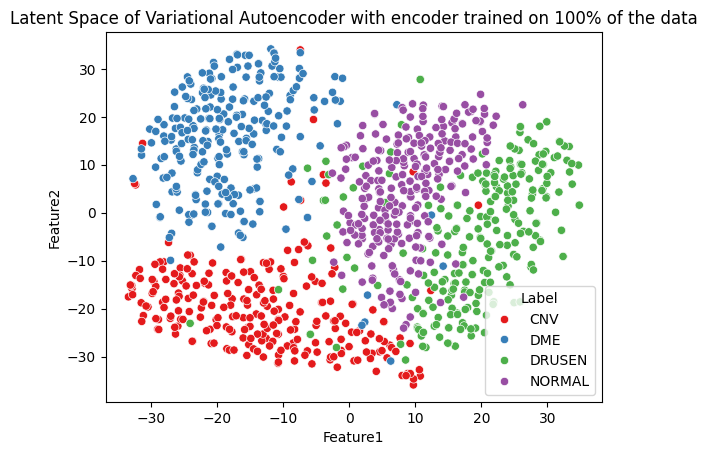

In [ ]:
encoded = encoded_data_per_eval[-1]
encoded_images, all_labels = encoded[:, :-1], encoded[:, -1]

tsne = TSNE(n_components=2)
tsne_out = tsne.fit_transform(encoded_images)
df = pd.DataFrame(tsne_out, columns=["Feature1", "Feature2"])
df["Label"] = all_labels
df["Label"] = df["Label"].map(data_classes)

sns.scatterplot(data=df, x="Feature1", y="Feature2", hue="Label", palette="Set1")

plt.title("Latent Space of Variational Autoencoder with encoder trained on " + str(int(train_set_pct*100)) +"% of the data")
plt.savefig("vae18_" + str(train_set_pct*100) +"clusterplot.jpeg")
plt.show()

# Checking the Quality of Clusters

First, in addition to my visual check of the clusters, I wanted to check the quality of clustering using the silhouette score.

I calculated the silhouette score (SS) for each comparison of normal and each of the three conditions (DME, DRUSEN, and CNV).

To explain briefly what the silhouette score is, it is a number ranging between -1 and 1 where more negative values indicate worse clustering, 0 indicates an overlap, and more positive values indicate better clustering.  

Here’s the formula:
s(i) = (b(i) - a(i))/max (a(i), b(i))

a(i) = avg distance of an observation to other points in the cluster

b(i) avg distance of an observation to other points in the nearest cluster.

I am following the above formula and averaging it for each point for each class to get the overall silhouette score.

In [ ]:
from sklearn.metrics import silhouette_score

encoded_images, all_labels = encoded[:, :-1], encoded[:, -1]

cnv_df = df.loc[(df.loc[:, "Label"] == "CNV") | (df.loc[:, "Label"] == "NORMAL")]
dme_df = df.loc[(df.loc[:, "Label"] == "DME") | (df.loc[:, "Label"] == "NORMAL")]
drusen_df = df.loc[(df.loc[:, "Label"] == "DRUSEN") | (df.loc[:, "Label"] == "NORMAL")]

cnv_normal_images = cnv_df.loc[:, ["Feature1", "Feature2"]].values
dme_normal_images = dme_df.loc[:, ["Feature1", "Feature2"]].values
drusen_normal_images = drusen_df.loc[:, ["Feature1", "Feature2"]].values
label = np.array([0 for _ in range(250)] + [1 for _ in range(250)])

print("CNV-NORMAL SS = " + str(silhouette_score(cnv_normal_images, label)))
print("DME-NORMAL SS = " + str(silhouette_score(dme_normal_images, label)))
print("DRUSEN-NORMAL SS = " + str(silhouette_score(drusen_normal_images, label)))

CNV-NORMAL SS = 0.50681835
DME-NORMAL SS = 0.49208367
DRUSEN-NORMAL SS = 0.21996951


# Finding the % of class detected as anomaly

First, I used the describe() function to see what the mean and standard deviation for the two features plotted was (for the normal images) as I need to use those values to compute the z score later.

In [ ]:
df.loc[df.loc[:,"Label"]=="NORMAL"].describe()

,Feature1,Feature2
count,250.000000,250.000000
mean,8.955534,4.926497
std,5.753597,11.318357
min,-2.579043,-24.065914
25%,4.602121,-3.574602
50%,8.570266,6.516564
75%,12.726035,14.032400
max,26.262123,24.694639


Here are the values I got as per the last time I ran this notebook.

In [ ]:
f1mean = 8.955534
f1std = 5.753597
f2mean = 4.926497
f2std = 11.318357

I defined the function that computes the 2D z score given a data frame.

In [ ]:
def twoDzScore(df):
    """
    Calculates the 2D z score given a data frame (using the previously found normal means and standard deviations
    as the default normal values)
    """
    z_scores = []
    for idx, row in df.iterrows():
      f1 = row["Feature1"]
      f2 = row["Feature2"]
      z = (((f1 - f1mean)/f1std)**2 +((f2 - f2mean)/f2std)**2)**0.5
      z_scores.append(z)
    df["z_score"] = z_scores
    return df

Using the threshold of three standard deviations away from the normal mean as an anomaly, I calculated how many of each of the retinal diseased OCT images were correctly flagged as anomalies with this method.

In [ ]:
cnvData = df.loc[df.loc[:,"Label"]=="CNV"].copy()
cnvData = twoDzScore(cnvData)
print((cnvData["z_score"] > 3).sum()/len(cnvData))

dmeData = df.loc[df.loc[:,"Label"]=="DME"].copy()
dmeData = twoDzScore(dmeData)
print((dmeData["z_score"] > 3).sum()/len(dmeData))

drusenData = df.loc[df.loc[:,"Label"]=="DRUSEN"].copy()
drusenData = twoDzScore(drusenData)
print((drusenData["z_score"] > 3).sum()/len(drusenData))

0.872
0.92
0.324


In [ ]:
normalData = df.loc[df.loc[:,"Label"]=="NORMAL"].copy()
normalData = twoDzScore(normalData)
print((normalData["z_score"] > 3).sum()/len(normalData))

0.004
